## LSTM from Scratch

A subcritically damped pendulum is described by the equation
$$x'' = -\sin(x) - \mu x'$$

where $x$ is the angle of the pendulum and $\mu$ is a damping parameter.

(i) Create a time-series data-set by using [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) to integrate this system in the interval $t\in[0,50]$ using $2,000$ time-steps using an initial condition of $x(t=0) = 0$,  $x'(t=0) = 1.2$. Plot the evolution of the pendulum angle and angular velocity as a function of time.

(ii) Implement an LSTM (Long short-term memory) with 8 lags, one hidden layer with 32 neurons, and a hyperbolic tangent activation function. Train the network using the data-set generated for $20,000$ stochastic gradient descent steps using the Adam optimizer with a learning rate of $10^{-3}$ and a mini-batch size of 128. Use the trained model to perform **one-step-ahead predictions** until the final time $T=60$, and compare them against the true data. Plot the predicted and exact signals, and report their discrepancy within the test interval in the relative $\mathbb{L}_{2}$ norm.


In [2]:
import jax
import jax.numpy as np
import numpy as onp
from jax import vmap, grad, random, jit
from jax.example_libraries import stax, optimizers
from jax.example_libraries.stax import Dense, Conv, Relu, MaxPool, Flatten, Softmax
from jax.lax import scan, fori_loop
import itertools
from functools import partial
from tqdm import trange
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

1. Plotting the Data:

In [3]:
y0 = [0, 1.2]
t = onp.linspace(0, 50, 2000)

In [4]:
# Define the 2nd order differential equation as a first order diff equan:
def pend(y, t):
  mu = 0.25
  theta, omega = y
  dydt = [omega, -mu*omega - np.sin(theta)]
  return dydt

from scipy.integrate import odeint
sol = odeint(pend, y0, t)

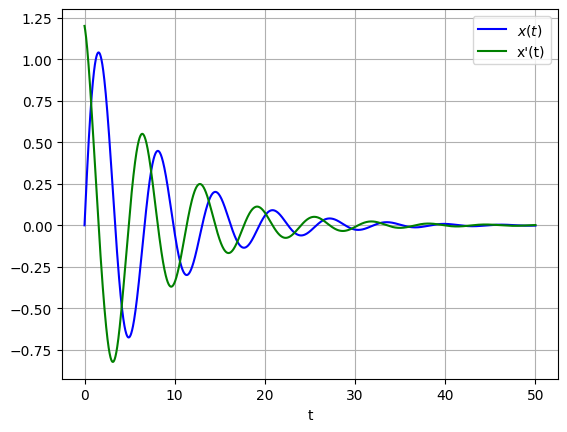

In [5]:
# Plot the angular velocity and position as function of time:
import matplotlib.pyplot as plt
plt.plot(t, sol[:, 0], 'b', label='$x(t)$')
plt.plot(t, sol[:, 1], 'g', label='x\'(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

2. LSTM implementation:

In [6]:
def LSTM(depth, dims, activation=np.tanh):
    input_dim, hidden_dim, output_dim = dims
    def init(rng_key):
        def glorot_init(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            return W
        keys = random.split(rng_key, 3)

        # 1. Parameters for forget gate:
        W_f = glorot_init(keys[1], hidden_dim, hidden_dim)
        U_f = glorot_init(keys[0], input_dim, hidden_dim)
        b_f = np.zeros(hidden_dim)

        # 2. Parameters for input gate:
        W_i = glorot_init(keys[1], hidden_dim, hidden_dim)
        U_i = glorot_init(keys[0], input_dim, hidden_dim)      
        b_i = np.zeros(hidden_dim)
       
        # 3. Parameters for cell state:
        W_s = glorot_init(keys[1], hidden_dim, hidden_dim)
        U_s = glorot_init(keys[0], input_dim, hidden_dim)
        b_s = np.zeros(hidden_dim)

        # 4. Parameters for output gate:
        W_o = glorot_init(keys[1], hidden_dim, hidden_dim)
        U_o = glorot_init(keys[0], input_dim, hidden_dim)
        b_o = np.zeros(hidden_dim)
        
        # 5. Output parameters:
        V = glorot_init(keys[2], hidden_dim, output_dim)
        c = np.zeros(output_dim)

        return W_f, U_f, b_f, W_i, U_i, b_i, W_s, U_s, b_s, W_o, U_o, b_o, V, c

    def scan_fn(params, H, inputs):
        Hidden, Cell = H

        W_f, U_f, b_f, W_i, U_i, b_i, W_s, U_s, b_s, W_o, U_o, b_o, _, _ = params

        # forget gate:
        f_t = jax.nn.sigmoid(np.dot(Hidden, W_f) + np.dot(inputs, U_f) + b_f) 

        # External input gate:
        i_t = jax.nn.sigmoid(np.dot(Hidden, W_i) + np.dot(inputs, U_i) + b_i)

        # Cell State:
        C_S = activation(np.dot(Hidden, W_s) + np.dot(inputs, U_s) + b_s)
        S_t = f_t * Cell + i_t * C_S

        # output gate:
        o_t = jax.nn.sigmoid(np.dot(Hidden, W_o) + np.dot(inputs, U_o) + b_o)

        # Current Hidden State:
        H_t = o_t * activation(S_t)

        H = H_t, S_t
        return H, H

    def apply(params, inputs):
        _, _, _, _, _, _, _, _, _, _, _, _, V, c = params
        f = partial(scan_fn, params)

        Hidden = np.zeros((inputs.shape[1], hidden_dim))
        Cell = np.zeros((inputs.shape[1], hidden_dim))

        H = Hidden, Cell
        H, _ = scan(f, H, inputs)

        H_t, S_t = H
        Output = np.dot(Hidden, V) + c

        return Output
    return init, apply

In [7]:
class Seq2Seq:
    # Initialize the class
    def __init__(self, depth, dims, rng_key=random.PRNGKey(0)):
        # MLP init and apply functions
        self.net_init, self.net_apply = LSTM(depth, dims)
        params = self.net_init(rng_key)

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps = 1000, decay_rate = 0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    def loss(self, params, batch):
        inputs, targets = batch
        outputs = self.net_apply(params, inputs)
        loss = np.mean((targets - outputs)**2)
        return loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [8]:
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, X, Y, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.batch_size = batch_size
        self.key = rng_key
    
    @partial(jit, static_argnums=(0,))  
    def __data_generation(self, key, X, Y):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[:,idx,:]
        targets = Y[idx,:]
        return inputs, targets

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(self.key, self.X, self.Y)
        return inputs, targets

In [9]:
def create_lags(data, lags):
    N = len(data) - lags
    data_dim = data.shape[1]
    X = np.zeros((lags, N, data_dim))
    Y = np.zeros((N, data_dim))
    for i in range(N):
        X = X.at[:, i ,:].set(data[i:(i+lags), :])
        Y = Y.at[i, :].set(data[i+lags, :])
    return X, Y


# Dataset:
theta = sol[:, 0].reshape(-1, 1)
omega = sol[:, 1].reshape(-1, 1)

# Normalize theta
mu_theta, std_theta = theta.mean(0), theta.std(0)
norm_theta = (theta - mu_theta) / std_theta

# Normalize omega
mu_omega, std_omega = omega.mean(0), omega.std(0)
norm_omega = (omega - mu_omega) / std_omega

# reshape X and Y
# X has the form lags x data x dim
# Y has the form data x dim
lags = 8
X_theta, Y_theta = create_lags(norm_theta, lags)
X_omega, Y_omega = create_lags(norm_omega, lags)

dataset_theta = DataGenerator(X_theta, Y_theta, batch_size=128)

dataset_omega = DataGenerator(X_omega, Y_omega, batch_size=128)

Plotting Lags to see what happened:

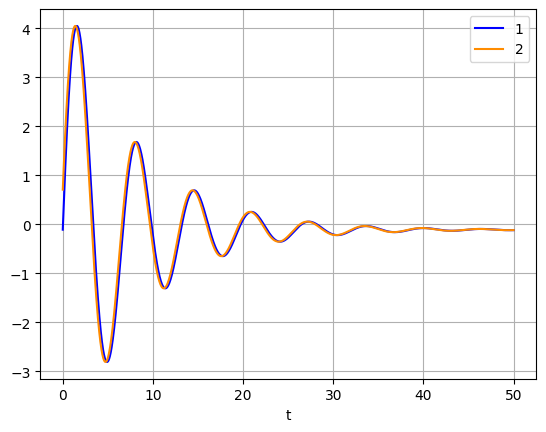

In [10]:
t = onp.linspace(0, 50, 1992)
import matplotlib.pyplot as plt
plt.plot(t, X_theta[0][:, 0], 'b', label='$1$')
plt.plot(t, X_theta[7][:, 0], 'darkorange', label='$2$')

plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

1. For $\theta$ (Angular Position):

In [11]:
# Initialize model for theta
inp_dim = X_theta.shape[-1]
out_dim = Y_theta.shape[-1]
hid_dim = 32
model = Seq2Seq(lags, (inp_dim, hid_dim, out_dim))

100%|██████████| 20000/20000 [02:14<00:00, 149.13it/s, Loss=0.91288084]


Text(0, 0.5, 'Loss')

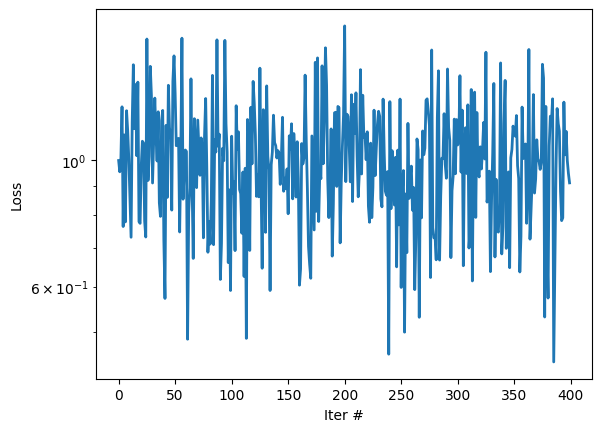

In [12]:
# Train the model
model.train(dataset_theta, nIter=20000)
opt_params = model.get_params(model.opt_state)

# Plotting loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [15]:
# one-step-ahead predictions
def pred(inputs, step):
  outputs = model.predict(opt_params, inputs)
  inputs = inputs.at[:-1].set(inputs[1:])
  inputs = inputs.at[-1].set(outputs)
  return inputs, outputs[-1]

steps = len(norm_theta) - lags
inputs, outputs = scan(pred, X_theta, np.arange(steps))


In [23]:
print(inputs[0].shape)

(1992, 1)


In [19]:
t = np.linspace(0, 60, 2400)

ValueError: ignored

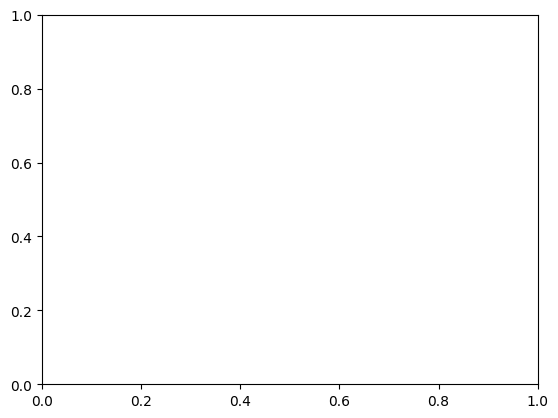

In [20]:
plt.plot(t[lags:], X_theta[0, lags:, 1], '-', lw = 2, label = "Actual")
plt.plot(t[lags:], outputs[:], '--', lw = 3, label = "Predicted")
plt.axvline(np.max(t), color='b', ls='--', lw=2)
plt.xlabel('t')
plt.ylabel('$\theta$')
plt.legend()

2. For $\dotθ$ (Angular Velocity i.e. $ω$)

In [24]:
# Initialize model for theta
inp_dim = X_omega.shape[-1]
out_dim = Y_omega.shape[-1]
hid_dim = 32
model = Seq2Seq(lags, (inp_dim, hid_dim, out_dim))

100%|██████████| 20000/20000 [02:13<00:00, 149.45it/s, Loss=0.8082518]


Text(0, 0.5, 'Loss')

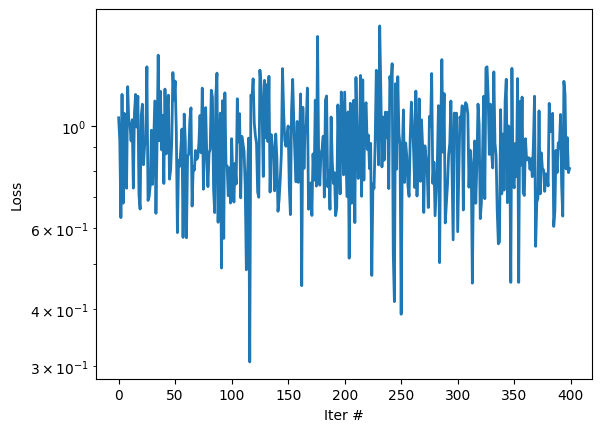

In [25]:
# Train the model
model.train(dataset_omega, nIter=20000)
opt_params = model.get_params(model.opt_state)

# Plotting loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [26]:
# one-step-ahead predictions
def pred(inputs, step):
  outputs = model.predict(opt_params, inputs)
  inputs = inputs.at[:-1].set(inputs[1:])
  inputs = inputs.at[-1].set(outputs)
  return inputs, outputs[-1]

steps = len(norm_omega)-lags
inputs, outputs = scan(pred, X_omega, np.arange(steps))

In [ ]:
t = np.linspace(0,60, 2000)

In [ ]:
plt.plot(t[lags:], X_omega[lags:], '-', lw = 2, label = "Actual")
plt.plot(t[lags:], outputs[:], '--', lw = 3, label = "Predicted")
plt.axvline(np.max(t), color='k', ls='--', lw=2)
plt.xlabel('t')
plt.ylabel('$\dot\theta$')
plt.legend()